In [68]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [69]:
from patsy import dmatrices
from statsmodels.formula.api import glm
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt

In [70]:
data = pd.read_csv('/Users/elizabethmurphy/Downloads/empirical_shedding_data.csv')
data = data.iloc[:, :-3]
data.head()
# solid_frac = Fraction of solids in the sample
# extraction_mass_mg = Mass used for RNA extraction
# N_conc (gc/mg-dw) = Viral nucleocapsid gene concentration
# N_det = Detection of N gene
# ORF1a_conc (gc/gm-dw) = ORF1a gene concentration
# ORF1a_det = Detection of ORF1a
# PMMoV_conc (gc/mg-dw) = Pepper mild mottle virus concentration
# PMMoV_det = Detection of PMMoV
# crAss_conc = crAssphage concentration
# crAss_quant = ?
# crAss_det = Detection of crAssphage

,ID,Day,solid_frac,extraction_mass_mg,N_conc (gc/mg-dw),N_det,ORF1a_conc (gc/gm-dw),ORF1a_det,PMMoV_conc (gc/mg-dw),PMMoV_det,crAss_conc,crAss_quant,crAss_det
0,4512,5,0.094133,11.5,1189.808219,True,3768.957713,True,NaN,False,1.054633e+07,True,True
1,4512,6,0.228228,17.5,649.722988,True,282.820595,True,175.807397,True,1.642356e+07,True,True
2,4512,7,0.187342,14.4,1203.595506,True,418.172285,True,941.273408,True,1.189325e+08,True,True
3,4514,13,0.135564,19.9,39.322095,False,39.322095,False,84.219268,False,2.540387e+02,False,True
4,4514,15,0.130321,16.7,59.181158,False,59.181158,True,771.928144,True,1.698420e+02,False,True


In [71]:
# Check for overdispersion
print(data["N_conc (gc/mg-dw)"].var()/data["N_conc (gc/mg-dw)"].mean()) # very high overdispersion
# Check for skew
data["N_conc (gc/mg-dw)"].skew() # data is right-skewed

971273.821965415


np.float64(9.10000045453068)

(0.0, 6000.0)

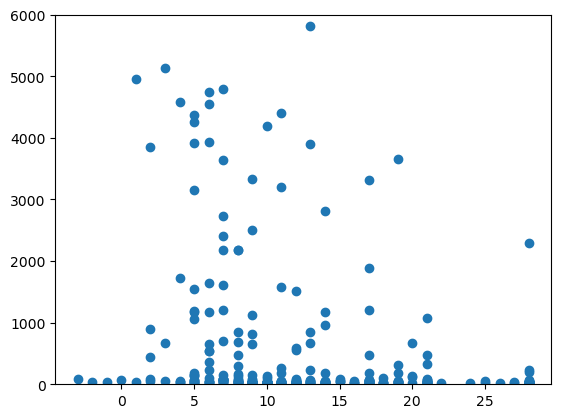

In [99]:
# plot shedding curve, not including outliers. 
fig,ax = plt.subplots()
ax.scatter(data['Day'],data['N_conc (gc/mg-dw)'])
ax.set_ylim([0,6000])

In [118]:
data['N_conc (gc/mg-dw)'] = data['N_conc (gc/mg-dw)'].fillna(0)
data['N_conc'] = data['N_conc (gc/mg-dw)']*data['N_det'] 
data['N_conc'] = pd.to_numeric(data['N_conc'], errors='coerce')
# If N_det is True: you get the original 'N_conc (gc/mg-dw)' value
# If N_det is False: the result becomes 0

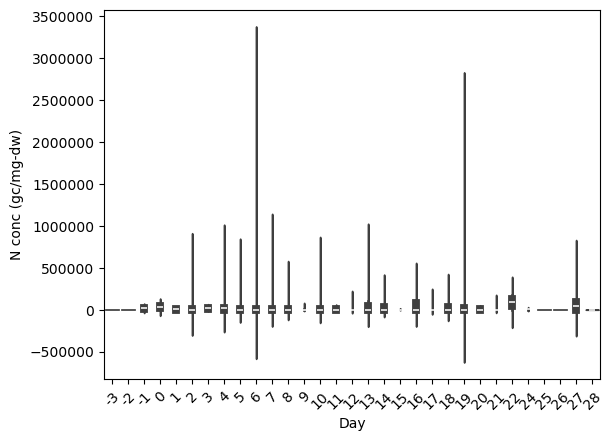

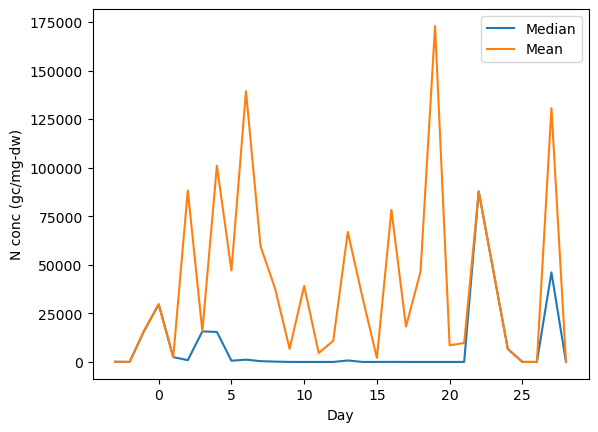

In [119]:
# Visualize Empirical Distributions Over Time
sns.violinplot(x='Day', y='N_conc', data=data)
plt.xticks(rotation=45)
plt.ticklabel_format(style='plain', axis='y')
plt.ylabel('N conc (gc/mg-dw)')
plt.show()


# Median & Mean shedding per day
median_by_day = data.groupby('Day')['N_conc'].median()
mean_by_day = data.groupby('Day')['N_conc'].mean()

plt.plot(median_by_day.index, median_by_day.values, label='Median')
plt.plot(mean_by_day.index, mean_by_day.values, label='Mean')
plt.xlabel('Day')
plt.ylabel('N conc (gc/mg-dw)')
plt.legend()

# Why is there a peak around day 20 for the mean and median ?


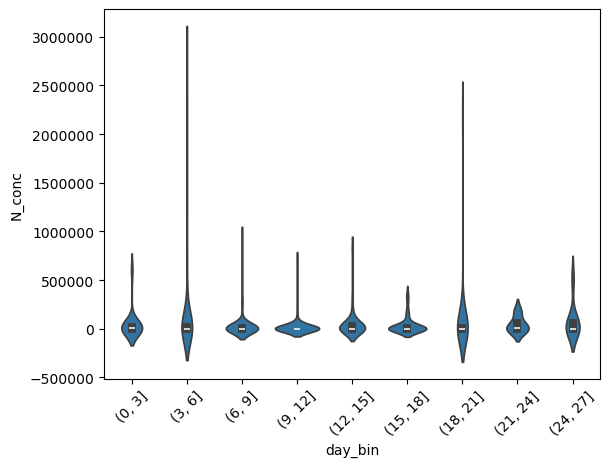

/var/folders/s2/nry612l527j2xxdsq0_70h6m0000gn/T/ipykernel_15956/1819042675.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  median_by_bin = data.groupby('day_bin')['N_conc'].median()
/var/folders/s2/nry612l527j2xxdsq0_70h6m0000gn/T/ipykernel_15956/1819042675.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_by_bin = data.groupby('day_bin')['N_conc'].mean()


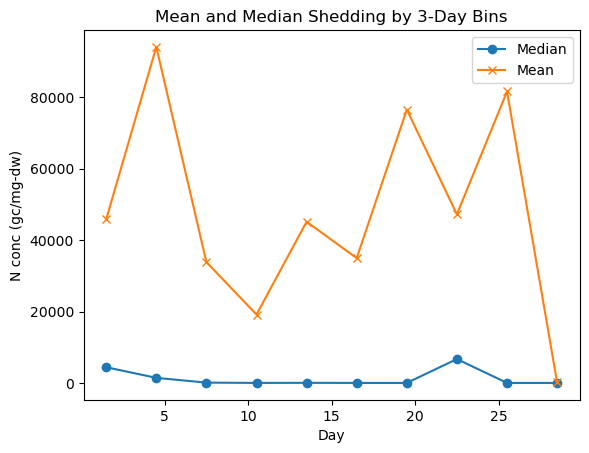

In [120]:
# Grouping days together
data['day_bin'] = pd.cut(data['Day'], bins=np.arange(0, 30, 3))  # 3 day bins
sns.violinplot(x='day_bin', y='N_conc', data=data)
plt.xticks(rotation=45)
plt.ticklabel_format(style='plain', axis='y')
plt.show()


# Median & Mean shedding (3 day bin)
data['day_bin'] = pd.cut(data['Day'], bins=np.arange(0, 33, 3))  # 3 day bin
median_by_bin = data.groupby('day_bin')['N_conc'].median()
mean_by_bin = data.groupby('day_bin')['N_conc'].mean()

bin_midpoints = median_by_bin.index.map(lambda x: x.left + (x.right - x.left)/2)

plt.plot(bin_midpoints, median_by_bin.values, label='Median', marker='o')
plt.plot(bin_midpoints, mean_by_bin.values, label='Mean', marker='x')
plt.xlabel('Day')
plt.ylabel('N conc (gc/mg-dw)')
plt.title('Mean and Median Shedding by 3-Day Bins')
plt.legend()

/Users/elizabethmurphy/miniconda3/envs/SRTI/lib/python3.13/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


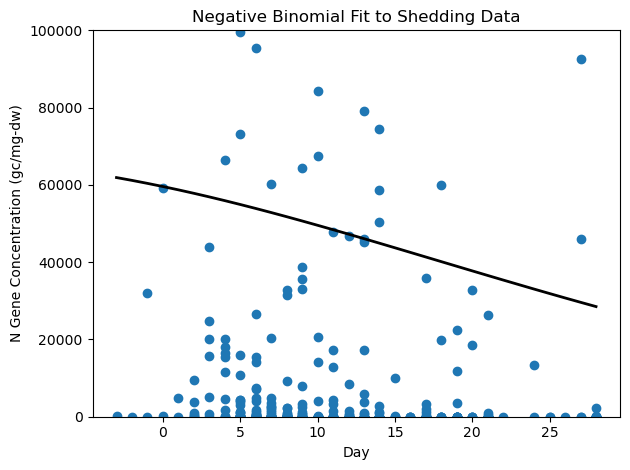

In [121]:
expr = " N_conc ~ Day + I(Day**2)"

y, X = dmatrices(expr, data, return_type='dataframe')
model = sm.GLM(y, X, family=sm.families.NegativeBinomial())
results = model.fit()
results.summary()

# Predict fitted values
data['fit'] = results.predict(X)
# Compute mean fitted value per day
mean_fit = data.groupby('Day')['fit'].mean().reset_index().sort_values('Day')

fig,ax = plt.subplots()
ax.scatter(data['Day'], data['N_conc'])
ax.plot(mean_fit['Day'], mean_fit['fit'], color='black', linewidth=2)
ax.set_ylim([0, 100000])
ax.set_xlabel("Day")
ax.set_ylabel("N Gene Concentration (gc/mg-dw)")
ax.set_title("Negative Binomial Fit to Shedding Data")
plt.tight_layout()

/var/folders/s2/nry612l527j2xxdsq0_70h6m0000gn/T/ipykernel_15956/2121502193.py:43: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  cdf['Sample_Date'] = pd.to_datetime(cdf['Sample_Date'])


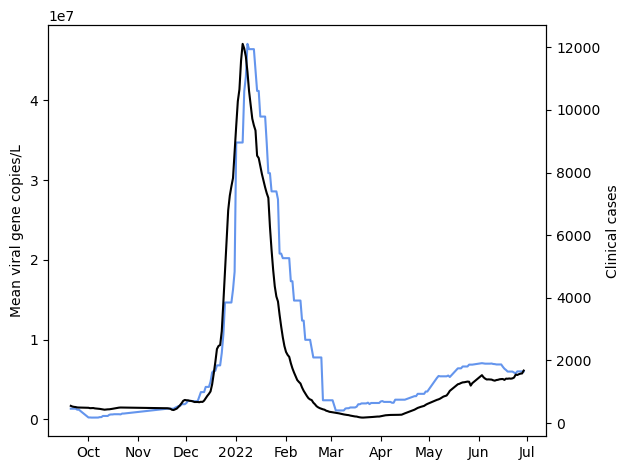

(CVXPY) Jun 27 01:53:47 PM: Your problem has 30 variables, 30 constraints, and 0 parameters.
(CVXPY) Jun 27 01:53:47 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jun 27 01:53:47 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jun 27 01:53:47 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jun 27 01:53:47 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jun 27 01:53:47 PM: Compiling problem (target solver=CLARABEL).
(CVXPY) Jun 27 01:53:47 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> CLARABEL
(CVXPY) Jun 27 01:53:47 PM: Applying reduction Dcp2Cone
(CVXPY) Jun 27 01:53:47 PM: Applying reduction CvxAttr2Constr
(CVXPY) Jun 27 01:53:47 PM: Applying reduction ConeMatrixStuffing
(CVXPY) Jun 27 01:53:47 PM: Applying reduction CLARABEL
(CVXPY) Jun 27 01:53:47 PM: Finished problem compilat

                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
-------------------------------------------------------------
           Clarabel.rs v0.11.1  -  Clever Acronym                

                   (c) Paul Goulart                          
                University of Oxford, 2022                   
-------------------------------------------------------------

problem:
  variables     = 31
  constraints 

(CVXPY) Jun 27 01:53:47 PM: Problem status: optimal
(CVXPY) Jun 27 01:53:47 PM: Optimal value: 8.113e+03
(CVXPY) Jun 27 01:53:47 PM: Compilation took 4.648e-03 seconds
(CVXPY) Jun 27 01:53:47 PM: Solver (including time spent in interface) took 3.946e-03 seconds
(CVXPY) Jun 27 01:53:47 PM: Your problem has 30 variables, 0 constraints, and 0 parameters.
(CVXPY) Jun 27 01:53:47 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jun 27 01:53:47 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jun 27 01:53:47 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jun 27 01:53:47 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jun 27 01:53:47 PM: Compiling problem (target solver=CLARABEL).
(CVXPY) Jun 27 01:53:47 PM: Reduction chain: FlipObjective -> Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> CLARABEL
(CVXPY) Jun 27 

  0  +0.0000e+00  -0.0000e+00  0.00e+00  8.17e-01  1.01e-02  1.00e+00  2.60e+04   ------   
  1  +6.3576e+03  +6.3842e+03  4.19e-03  1.98e-01  1.93e-04  2.67e+01  3.00e+03  8.86e-01  
  2  +6.8042e+03  +7.0396e+03  3.46e-02  1.45e-01  1.33e-04  2.35e+02  2.68e+03  2.39e-01  
  3  +7.5963e+03  +7.7996e+03  2.68e-02  3.10e-02  2.59e-05  2.03e+02  1.59e+03  7.80e-01  
  4  +7.4796e+03  +7.9045e+03  5.68e-02  5.00e-02  4.18e-05  4.25e+02  1.55e+03  1.64e-01  
  5  +7.5917e+03  +7.6848e+03  1.23e-02  1.45e-02  1.21e-05  9.31e+01  5.13e+02  7.38e-01  
  6  +7.8421e+03  +7.8894e+03  6.04e-03  4.71e-03  3.87e-06  4.74e+01  1.16e+02  8.34e-01  
  7  +7.9723e+03  +7.9882e+03  2.00e-03  1.82e-03  1.49e-06  1.60e+01  4.35e+01  7.00e-01  
  8  +8.0359e+03  +8.0523e+03  2.05e-03  1.46e-03  1.19e-06  1.65e+01  2.38e+01  5.79e-01  
  9  +8.0958e+03  +8.0979e+03  2.60e-04  2.82e-04  2.28e-07  2.11e+00  5.04e+00  8.40e-01  
 10  +8.1110e+03  +8.1112e+03  2.99e-05  3.86e-05  3.13e-08  2.43e-01  7.02e-01 

(CVXPY) Jun 27 01:53:47 PM: Problem status: optimal
(CVXPY) Jun 27 01:53:47 PM: Optimal value: -1.400e+02
(CVXPY) Jun 27 01:53:47 PM: Compilation took 8.184e-03 seconds
(CVXPY) Jun 27 01:53:47 PM: Solver (including time spent in interface) took 1.042e-02 seconds


  0  +0.0000e+00  -4.2154e+02  4.22e+02  8.86e-01  1.26e+01  1.00e+00  1.00e+00   ------   
  1  +1.6563e+02  -3.6742e-01  1.66e+02  2.62e-01  3.99e+00  5.73e-01  2.94e-01  7.28e-01  
  2  +1.3699e+02  +4.6079e+01  1.97e+00  1.56e-01  2.09e+00  2.78e-01  1.72e-01  5.57e-01  
  3  +1.2841e+02  +8.2480e+01  5.57e-01  8.14e-02  9.02e-01  1.37e-01  8.88e-02  5.54e-01  
  4  +1.2812e+02  +9.8253e+01  3.04e-01  5.54e-02  4.25e-01  9.29e-02  5.55e-02  5.37e-01  
  5  +1.3389e+02  +1.1626e+02  1.52e-01  3.43e-02  1.47e-01  6.16e-02  2.90e-02  6.07e-01  
  6  +1.3748e+02  +1.2729e+02  8.00e-02  2.02e-02  6.18e-02  3.83e-02  1.52e-02  5.00e-01  
  7  +1.3963e+02  +1.3723e+02  1.75e-02  4.80e-03  1.19e-02  8.57e-03  3.35e-03  9.90e-01  
  8  +1.3994e+02  +1.3939e+02  3.92e-03  1.10e-03  2.52e-03  1.99e-03  7.44e-04  7.92e-01  
  9  +1.4001e+02  +1.4000e+02  7.71e-05  2.17e-05  4.89e-05  4.14e-05  1.46e-05  9.90e-01  
 10  +1.4002e+02  +1.4001e+02  1.65e-05  4.65e-06  1.05e-05  8.89e-06  3.13e-06 

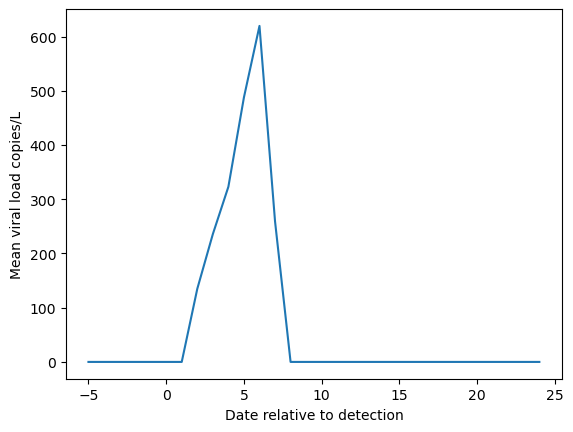

In [122]:
import pandas as pd
import pickle
import json
import requests
from scipy import signal
from datetime import date,timedelta
import yaml
import copy
import numpy as np

import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

start = pd.to_datetime('2023-01-01')
eval_dates = [start + datetime.timedelta(days=7*j) for j in range(0,52)]

cases = pd.read_csv('/Users/elizabethmurphy/Downloads/covid19cases_test.csv',index_col=0)
cases = cases[cases['area'] =='San Diego']
cases = cases[(cases.index>='2020-06-01') & (cases.index<='2022-07-01')]
cases.index = pd.to_datetime(cases.index)

cases['cases'] = cases['cases'].rolling(window=7, center=True, min_periods=0).mean()
cases['positivity'] = cases['cases'].rolling(window=7, center=True, min_periods=0).mean()/cases['total_tests'].rolling(window=7, center=True, min_periods=0).mean()

ww_dict = {'Point Loma':['/Users/elizabethmurphy/Downloads/PointLoma_sewage_seqs.csv','/Users/elizabethmurphy/Downloads/PointLoma_sewage_qPCR.csv']}
for site, files in zip(ww_dict.keys(),ww_dict.values()):
    df = pd.read_csv(f'{files[0]}')

    df['Date'] = pd.to_datetime(df['Date'])
    df.columns = [dfc.split(' (')[0] for dfc in df.columns]
    df =df.set_index('Date')
    df = df[df.index>='2020-06-01']
    df = df[df.index<='2022-07-01']
    df = df.dropna(axis = 0, how = 'all')
    df = df.fillna(0)
    df = df/100.

    df = df.drop(columns=['Other'])
    df = df[df.columns[df.sum(axis=0) > 0.01]]

    cdf = pd.read_csv(f'{files[1]}')
    cdf['Sample_Date'] = pd.to_datetime(cdf['Sample_Date'])
    cdf =cdf.set_index('Sample_Date')
    sharedInds = np.sort(list(set(cdf.index) & set(df.index)))
    cdf = cdf.loc[sharedInds]
    df = df.loc[sharedInds]
    df = df[~df.index.duplicated(keep='last')]
    scaleddf = df.mul(cdf['Mean viral gene copies/L'],axis=0)

    cdf = cdf.resample('D').asfreq()
    cdf = cdf.rolling(window=7, center=True, min_periods=0).mean()


cdf = pd.concat([cdf,cases],axis=1)
cdf = cdf.dropna(how='any')

N = 30
F = 5
# first, let's learn the shedding kernel. 
X = np.array([cdf['Mean viral gene copies/L'].values[(j-F):(j+N-F)] for j in range(F,(cdf.shape[0]-N+F))])/cdf['Mean viral gene copies/L'].mean()
#add coeficient term
Y= cdf['cases'].values[F:(len(cdf['cases'])-N+F)]

import cvxpy as cp

fig,ax = plt.subplots()
ax.plot(cdf.index,cdf['Mean viral gene copies/L'],color='cornflowerblue')
ax.set_ylabel('Mean viral gene copies/L')
ax2 = ax.twinx()
ax2.plot(cdf.index,cdf['cases'],color='black')
ax2.set_ylabel('Clinical cases')
locator = mdates.MonthLocator(bymonthday=1)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(locator))
fig.tight_layout()
plt.show()

# least squares problem
x = cp.Variable(N)
cost = cp.norm(X @ x - Y,2)
constraints = [x >= 0]
prob = cp.Problem(cp.Minimize(cost),constraints)
prob.solve(verbose=True)#,solver=cp.CLARABEL)

Y2= cdf['positivity'].values[0:(len(cdf['positivity'])-N)]

#switch to logistic function
beta = cp.Variable(N,nonneg=True)#+1)
log_likelihood = cp.sum(
    cp.multiply(Y2, X @ beta) - cp.logistic(X @ beta)
)
# constraints = [beta >= 0.001, beta<=10]
prob2 = cp.Problem(cp.Maximize(log_likelihood))#,constraints)
prob2.solve(verbose=True)#,solver=cp.CLARABEL)

fig,ax = plt.subplots()
ax.plot(range(-F,len(x.value)-F),x.value) # just plotting the curve learned via the case counts for now. 
ax.set_xlabel('Date relative to detection')
ax.set_ylabel('Mean viral load copies/L')
plt.show()